#### Importing Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (14, 6)
sns.set_style("whitegrid")

#### Parameters

In [2]:
start = "2016-01-01"
end = "2026-01-01"

tickers = ["AAPL", "MSFT", "GOOGL"]

In [3]:
# Risk-Free Rate for Sharpe (Annual)
RISK_FREE_RATE = 0.02
TRADING_DAYS = 252

#### Downloading Data (Robust Handling of )

In [4]:
raw = yf.download(
    tickers=tickers,
    start=start,
    end=end,
    auto_adjust=True,
    group_by="ticker",
    progress=False
)

raw.head()

Ticker           MSFT                                                  AAPL  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2016-01-04  47.563159  47.983452  46.748841  47.983452  53778000  23.135372   
2016-01-05  48.097297  48.500077  47.755810  48.202370  34079700  23.843333   
2016-01-06  47.563159  47.633210  46.967744  47.326744  39518900  22.673156   
2016-01-07  46.144679  46.836412  45.593043  45.680603  56564900  22.249279   
2016-01-08  45.855727  46.652533  45.663095  45.820705  48754000  22.219958   

Ticker                                                      GOOGL             \
Price            High        Low      Close     Volume       Open       High   
Date                                                                           
2016-01-04  23.757667  22.997836  23.753157  270597600  37.824214  37.824214   
2016-01-05  23.865880  23.090268  23.157907  223164000  37.918504  38.171589   
2016-01-06  23.081256  22.517584  22.704721  273829600  37.237151  37.999389   
2016-01-07  22.576209  21.741974  21.746483  324377600  37.044603  37.482294   
2016-01-08  22.346220  21.816369  21.861462  283192000  37.109607  37.224738   

Ticker                                      
Price             Low      Close    Volume  
Date                                        
2016-01-04  37.096709  37.687248  67382000  
2016-01-05  37.499172  37.790966  45216000  
2016-01-06  37.119540  37.681789  48206000  
2016-01-07  36.488305  36.772160  63132000  
2016-01-08  36.172686  36.271442  47506000

#### Reshaping to a Clean Long Format (Recommended for Multi-Ticker Analysis)

In [5]:
if isinstance(raw.columns, pd.MultiIndex) :
    # Detect Ordering
    level0 = raw.columns.get_level_values(0).unique()
    level1 = raw.columns.get_level_values(1).unique()

    # If level0 looks like OHLCV fields, it's (Field, Ticker). Otherwise it's (Ticker, Field).
    ohlcv = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}
    if set(level0).intersection(ohlcv):
        # (Field, Ticker) -> swap to (Ticker, Field)
        raw = raw.swaplevel(axis=1)

In [6]:
# Now assume columns are (Ticker, Field)
data_long = (
    raw.stack(level=0)
       .rename_axis(["Date", "Ticker"])
       .reset_index()
)

data_long.head()

Price,Date,Ticker,Open,High,Low,Close,Volume
0,2016-01-04,AAPL,23.135372,23.757667,22.997836,23.753157,270597600
1,2016-01-04,GOOGL,37.824214,37.824214,37.096709,37.687248,67382000
2,2016-01-04,MSFT,47.563159,47.983452,46.748841,47.983452,53778000
3,2016-01-05,AAPL,23.843333,23.865880,23.090268,23.157907,223164000
4,2016-01-05,GOOGL,37.918504,38.171589,37.499172,37.790966,45216000


In [7]:
data_long[data_long['Ticker']=='GOOGL']

Price,Date,Ticker,Open,High,Low,Close,Volume
1,2016-01-04,GOOGL,37.824214,37.824214,37.096709,37.687248,67382000
4,2016-01-05,GOOGL,37.918504,38.171589,37.499172,37.790966,45216000
7,2016-01-06,GOOGL,37.237151,37.999389,37.119540,37.681789,48206000
10,2016-01-07,GOOGL,37.044603,37.482294,36.488305,36.772160,63132000
13,2016-01-08,GOOGL,37.109607,37.224738,36.172686,36.271442,47506000
...,...,...,...,...,...,...,...
7528,2025-12-24,GOOGL,314.769989,315.079987,311.920013,314.089996,10097400
7531,2025-12-26,GOOGL,314.480011,315.089996,312.279999,313.510010,10899000
7534,2025-12-29,GOOGL,311.369995,314.019989,310.619995,313.559998,19621800
7537,2025-12-30,GOOGL,312.500000,316.950012,312.459991,313.850006,17380900


#### Basic Checks (Shapes, Types, Missing Values)

In [9]:
print("Rows:", len(data_long))
print("Tickers:", data_long["Ticker"].nunique())
print("Date range:", data_long["Date"].min(), "to", data_long["Date"].max())

Rows: 7542
Tickers: 3
Date range: 2016-01-04 00:00:00 to 2025-12-31 00:00:00


In [10]:
data_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7542 entries, 0 to 7541
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7542 non-null   datetime64[ns]
 1   Ticker  7542 non-null   object        
 2   Open    7542 non-null   float64       
 3   High    7542 non-null   float64       
 4   Low     7542 non-null   float64       
 5   Close   7542 non-null   float64       
 6   Volume  7542 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 412.6+ KB


In [11]:
# Missing values summary per column
print("\nMissing values (overall):")
print(data_long.isnull().sum())


Missing values (overall):
Price
Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [12]:
print("\nMissing values per ticker:")
print(data_long.groupby("Ticker").apply(lambda x: x.isnull().sum()))


Missing values per ticker:
Price   Date  Ticker  Open  High  Low  Close  Volume
Ticker                                              
AAPL       0       0     0     0    0      0       0
GOOGL      0       0     0     0    0      0       0
MSFT       0       0     0     0    0      0       0


#### Missing Data Visulaization

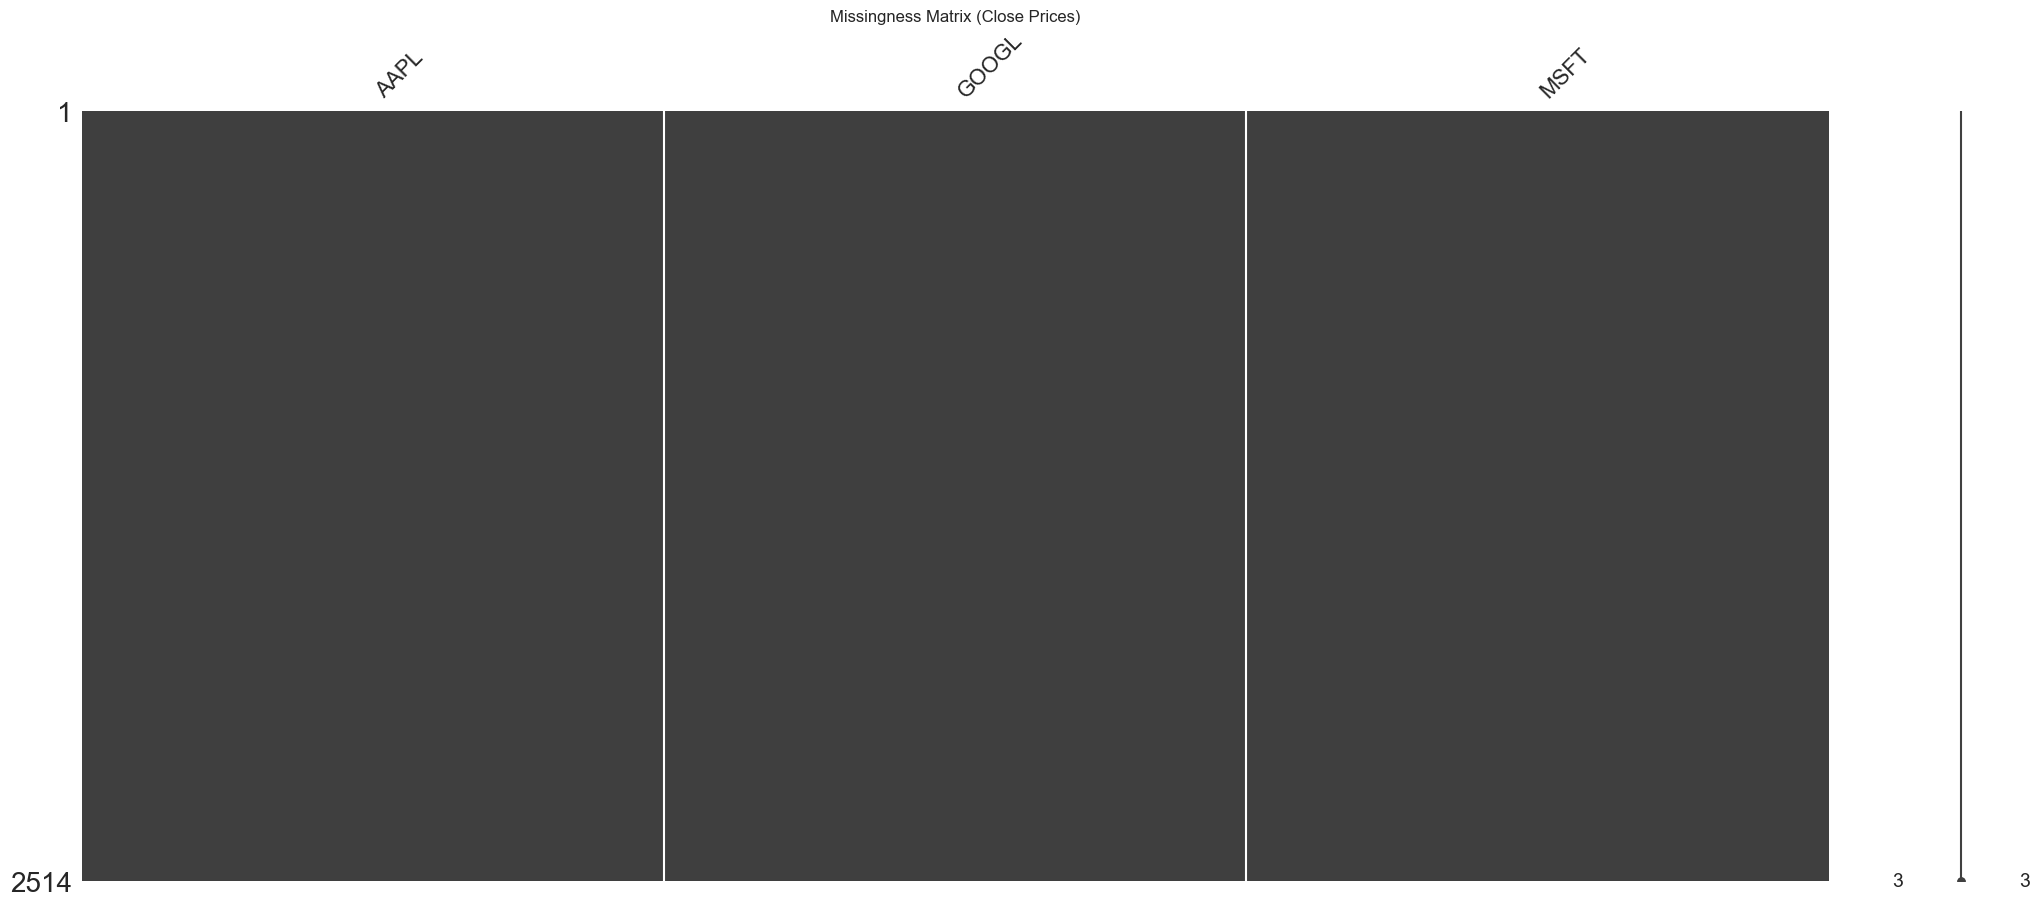

In [13]:
# Pivot to wide so missingno can show per ticker fields clearly
wide_close = data_long.pivot(index="Date", columns="Ticker", values="Close")

msno.matrix(wide_close)
plt.title("Missingness Matrix (Close Prices)")
plt.show()

#### Feature Engineering: Daily Range, Returns, Log Returns

In [15]:
data_long["Range"] = data_long["High"] - data_long["Low"]

# Sort properly before pct_change / diff
data_long = data_long.sort_values(["Ticker", "Date"])

data_long["Return"] = data_long.groupby("Ticker")["Close"].pct_change()

data_long["LogReturn"] = data_long.groupby("Ticker")["Close"].transform(
    lambda s: np.log(s).diff()
)

data_long.head()

Price,Date,Ticker,Open,High,Low,Close,Volume,Range,Return,LogReturn
0,2016-01-04,AAPL,23.135372,23.757667,22.997836,23.753157,270597600,0.759831,NaN,NaN
3,2016-01-05,AAPL,23.843333,23.865880,23.090268,23.157907,223164000,0.775612,-0.025060,-0.025379
6,2016-01-06,AAPL,22.673156,23.081256,22.517584,22.704721,273829600,0.563672,-0.019569,-0.019763
9,2016-01-07,AAPL,22.249279,22.576209,21.741974,21.746483,324377600,0.834235,-0.042204,-0.043121
12,2016-01-08,AAPL,22.219958,22.346220,21.816369,21.861462,283192000,0.529852,0.005287,0.005273


#### Summary Statistics

In [19]:
pd.set_option("display.float_format", "{:,.4f}".format)

summary = (
    data_long
    .groupby("Ticker")[["Open", "High", "Low", "Close", "Volume", "Range", "Return"]]
    .describe()
    .transpose()
)

summary

Ticker                   AAPL            GOOGL             MSFT
Price                                                          
Open   count       2,514.0000       2,514.0000       2,514.0000
       mean          114.1824          99.9829         222.7511
       std            73.2780          56.5935         139.8718
       min            20.5265          33.8686          42.6247
       25%            41.5118          54.0736          93.8375
       50%           120.5813          87.3897         212.9403
       75%           171.4762         136.4193         324.3967
       max           286.2000         325.9968         553.2832
High   count       2,514.0000       2,514.0000       2,514.0000
       mean          115.4243         101.0882         224.8117
       std            74.0458          57.2703         140.9776
       min            20.9074          33.9103          43.4040
       25%            41.8013          54.7624          94.6724
       50%           121.7180          88.1869         214.6892
       75%           173.1333         137.5110         326.9390
       max           288.6200         328.6150         553.5024
Low    count       2,514.0000       2,514.0000       2,514.0000
       mean          113.0441          98.9154         220.5798
       std            72.5805          55.9155         138.6452
       min            20.4057          33.3808          42.1957
       25%            41.1442          53.3896          92.8917
       50%           118.8741          86.2617         209.4089
       75%           169.7614         135.0536         321.0754
       max           283.3000         318.9614         539.7598
Close  count       2,514.0000       2,514.0000       2,514.0000
       mean          114.2916         100.0314         222.7953
       std            73.3505          56.6101         139.8523
       min            20.6041          33.8016          43.0090
       25%            41.5312          54.0803          93.9524
       50%           120.3792          87.3433         212.9977
       75%           171.6608         136.5041         323.8838
       max           286.1900         323.2286         541.0574
Volume count       2,514.0000       2,514.0000       2,514.0000
       mean  101,776,615.3540  34,458,431.2649  27,505,737.0326
       std    57,975,027.1233  15,996,075.2111  12,393,565.7543
       min    17,910,600.0000   9,312,000.0000   5,855,900.0000
       25%    61,763,125.0000  24,444,000.0000  19,653,050.0000
       50%    88,783,600.0000  30,451,900.0000  24,308,100.0000
       75%   124,475,250.0000  39,278,475.0000  31,557,675.0000
       max   533,478,800.0000 140,798,000.0000 133,503,000.0000
Range  count       2,514.0000       2,514.0000       2,514.0000
       mean            2.3802           2.1728           4.2319
       std             2.1558           1.8248           3.4348
       min             0.1323           0.1762           0.2753
       25%             0.6556           0.8511           1.3557
       50%             1.9765           1.7468           3.6293
       75%             3.4091           2.9180           6.0655
       max            28.6221          17.7384          39.9160
Return count       2,513.0000       2,513.0000       2,513.0000
       mean            0.0011           0.0010           0.0011
       std             0.0183           0.0182           0.0169
       min            -0.1286          -0.1163          -0.1474
       25%            -0.0071          -0.0074          -0.0066
       50%             0.0011           0.0013           0.0010
       75%             0.0100           0.0101           0.0097
       max             0.1533           0.1022           0.1422

#### Price Trends : Close Prices (All Tickers)

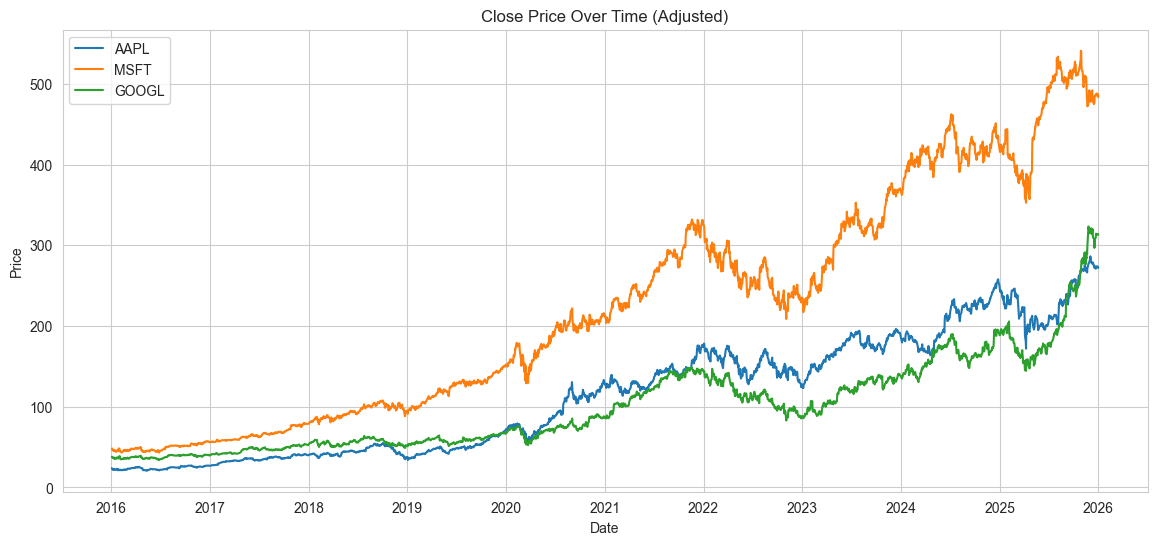

In [20]:
wide_close = data_long.pivot(index="Date", columns="Ticker", values="Close")

plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(wide_close.index, wide_close[t], label=t)
plt.title("Close Price Over Time (Adjusted)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Volume Trends (All Tickers)

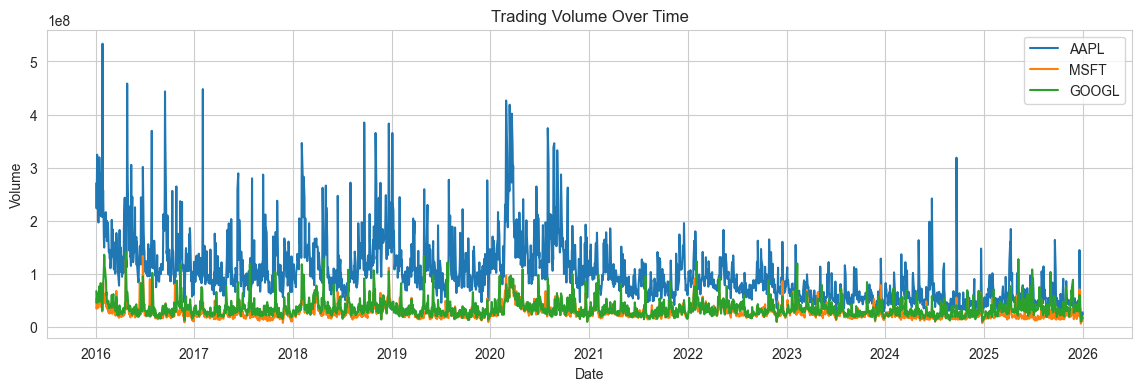

In [21]:
wide_vol = data_long.pivot(index="Date", columns="Ticker", values="Volume")

plt.figure(figsize=(14,4))
for t in tickers:
    plt.plot(wide_vol.index, wide_vol[t], label=t)
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

#### Correlation Analysis (Returns Based)

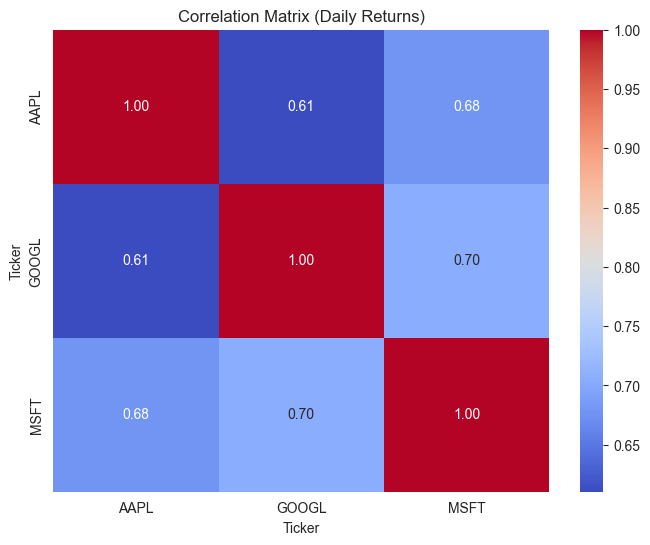

In [22]:
wide_ret = data_long.pivot(index="Date", columns="Ticker", values="Return")

plt.figure(figsize=(8,6))
sns.heatmap(wide_ret.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Daily Returns)")
plt.show()

#### Moving Averages (Per Ticker)

In [23]:
def plot_moving_averages(ticker, windows=(100, 200)):
    s = data_long.loc[data_long["Ticker"] == ticker].set_index("Date")["Close"]
    plt.figure(figsize=(14,6))
    plt.plot(s, label=f"{ticker} Close")

    for w in windows:
        plt.plot(s.rolling(w).mean(), label=f"{ticker} MA {w}", linestyle="--")

    plt.title(f"{ticker}: Close Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

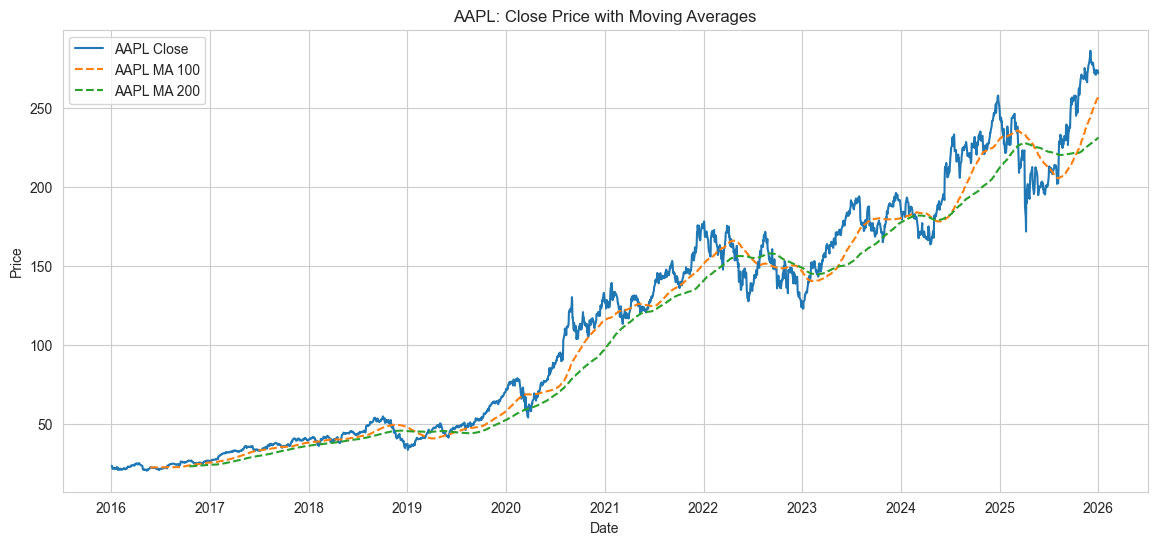

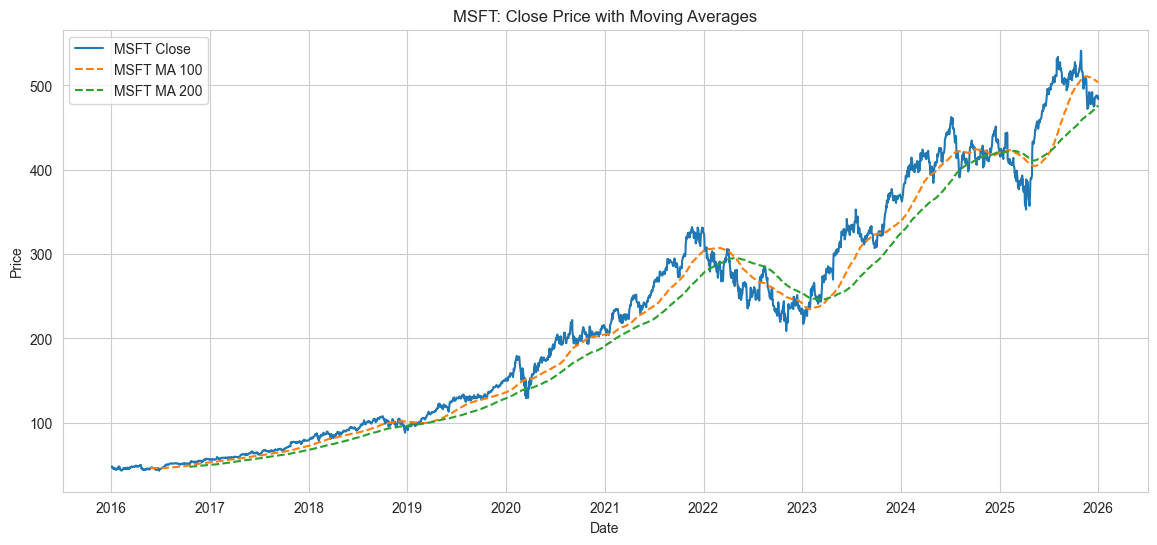

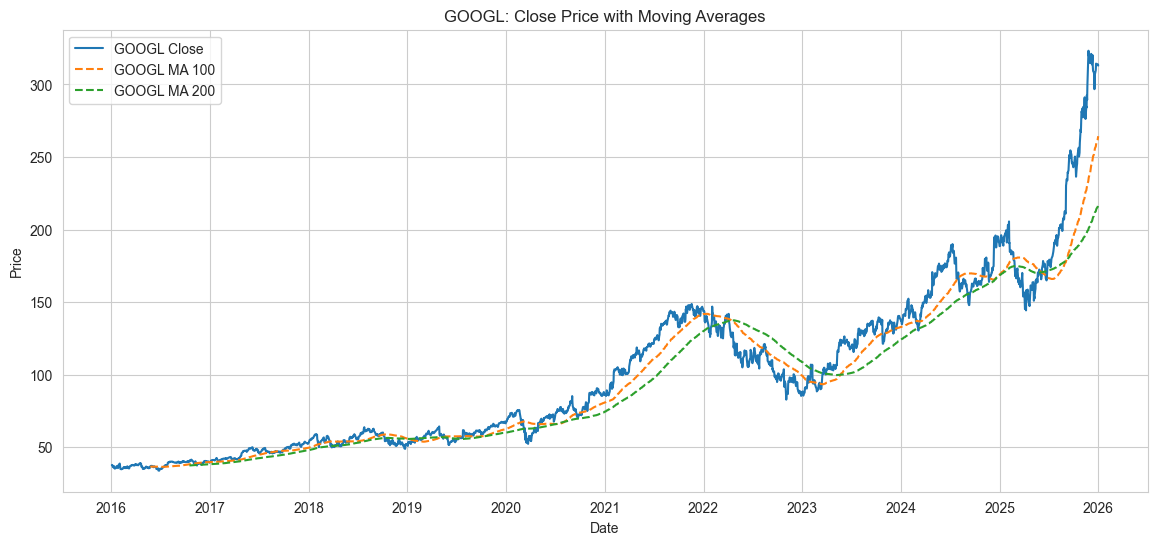

In [24]:
for t in tickers:
    plot_moving_averages(t, windows=(100, 200))

#### Cumulative Returns

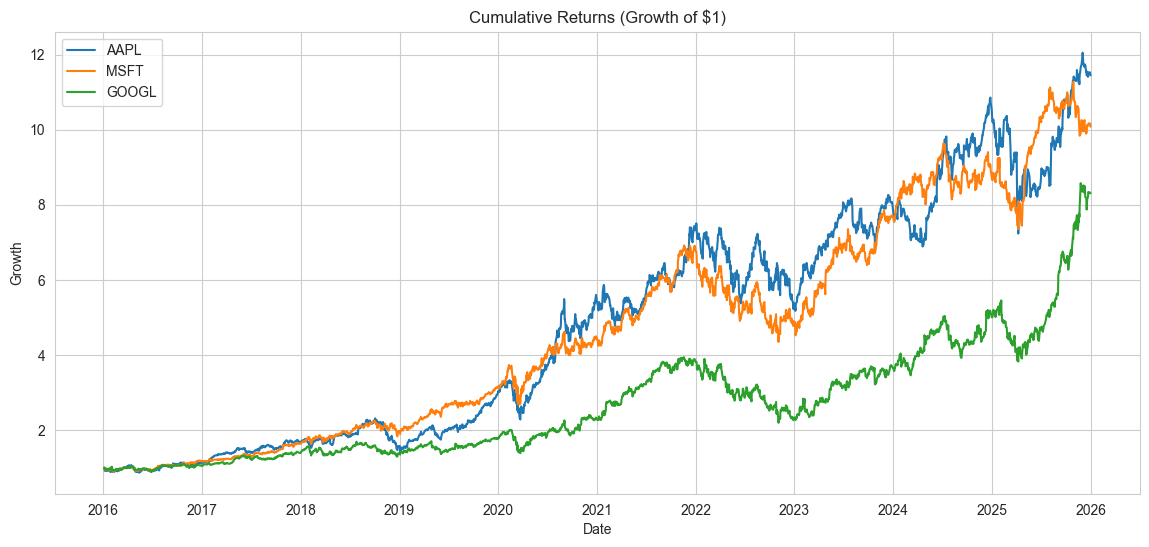

In [25]:
cum_ret = (1 + wide_ret.fillna(0)).cumprod()

plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(cum_ret.index, cum_ret[t], label=t)
plt.title("Cumulative Returns (Growth of $1)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.legend()
plt.show()

#### Rolling Volatility (Annualized)

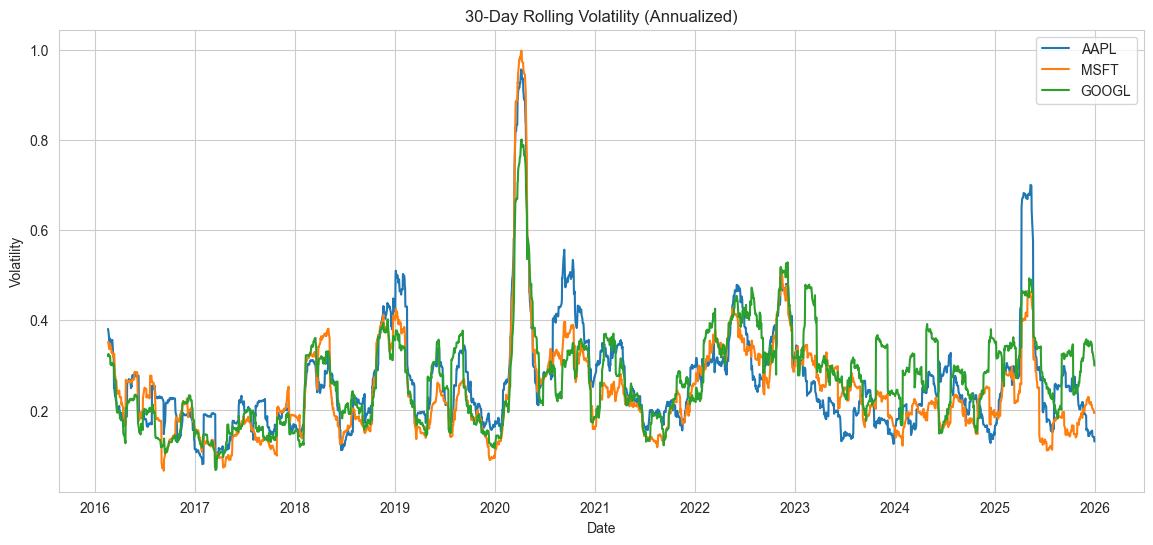

In [26]:
rolling_window = 30
rolling_vol = wide_ret.rolling(rolling_window).std() * np.sqrt(TRADING_DAYS)

plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(rolling_vol.index, rolling_vol[t], label=t)
plt.title(f"{rolling_window}-Day Rolling Volatility (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

#### Drawdown Analysis (Risk/Peak-To-Trough Declines)

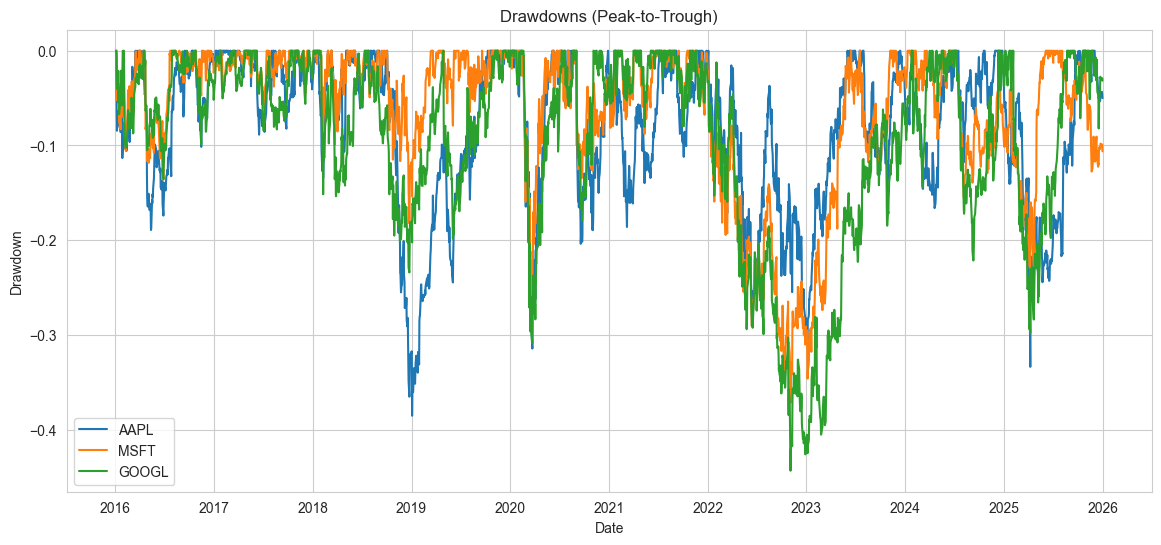

In [27]:
def compute_drawdown(price_series: pd.Series) -> pd.Series:
    running_max = price_series.cummax()
    drawdown = price_series / running_max - 1.0
    return drawdown

drawdowns = wide_close.apply(compute_drawdown)

plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(drawdowns.index, drawdowns[t], label=t)
plt.title("Drawdowns (Peak-to-Trough)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

In [28]:
print("Maximum drawdown:")
print(drawdowns.min().sort_values())

Maximum drawdown:
Ticker
GOOGL   -0.4432
AAPL    -0.3852
MSFT    -0.3715
dtype: float64


#### Basic Performance Metrics (CAGR, Volatility, Sharpe)

In [29]:
def perf_metrics(price: pd.Series, ret: pd.Series, rf=RISK_FREE_RATE):
    price = price.dropna()
    ret = ret.dropna()

    years = (price.index[-1] - price.index[0]).days / 365.25
    cagr = (price.iloc[-1] / price.iloc[0]) ** (1 / years) - 1

    ann_vol = ret.std() * np.sqrt(TRADING_DAYS)
    ann_ret = ret.mean() * TRADING_DAYS

    sharpe = (ann_ret - rf) / ann_vol if ann_vol != 0 else np.nan
    return pd.Series({"CAGR": cagr, "AnnualReturn": ann_ret, "AnnualVol": ann_vol, "Sharpe": sharpe})

metrics = pd.DataFrame({
    t: perf_metrics(wide_close[t], wide_ret[t]) for t in tickers
}).T

metrics.sort_values("Sharpe", ascending=False)

,CAGR,AnnualReturn,AnnualVol,Sharpe
MSFT,0.2602,0.2676,0.2676,0.9252
AAPL,0.2763,0.2867,0.2905,0.9180
GOOGL,0.2360,0.2539,0.2883,0.8113


#### Monthly Returns Heatmap

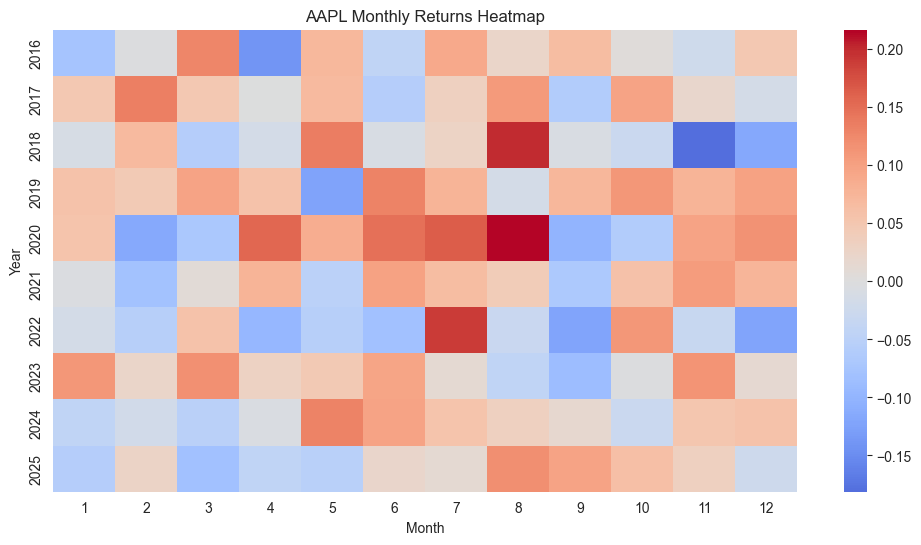

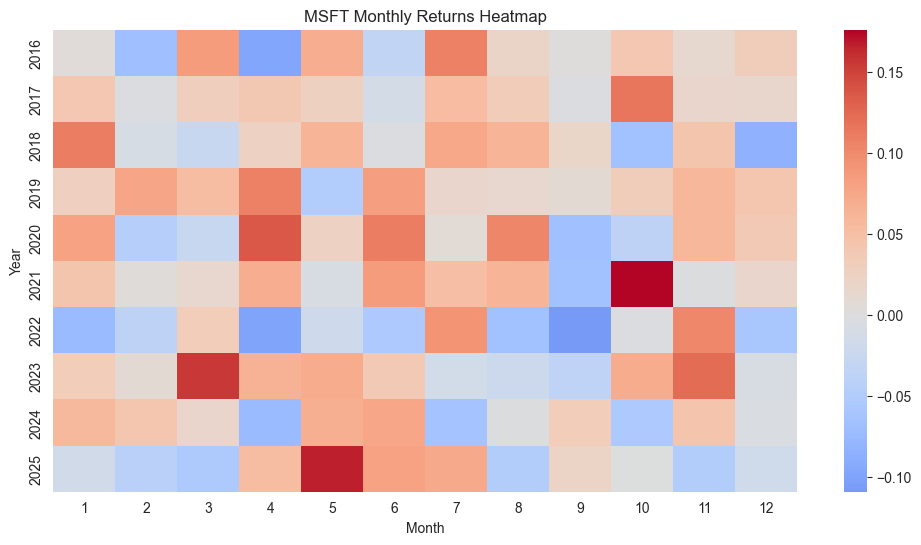

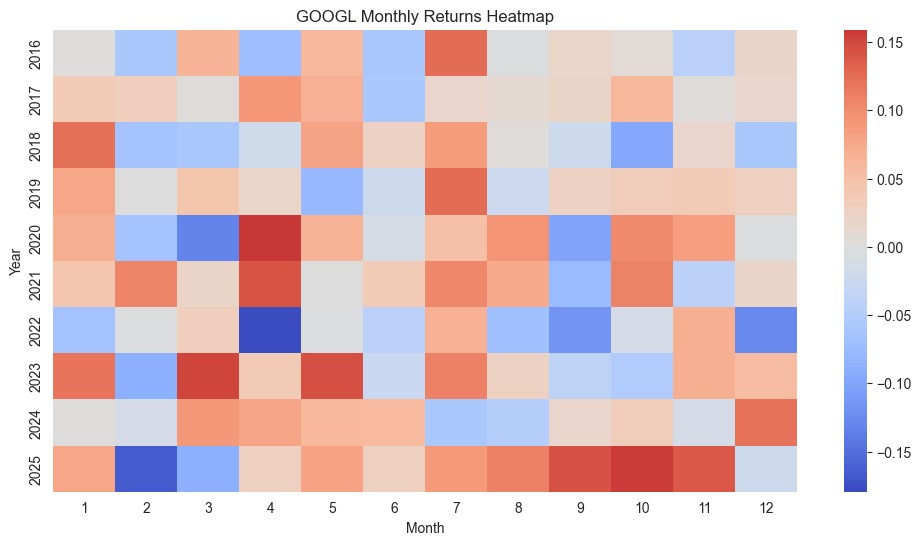

In [30]:
monthly_ret = wide_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)

for t in tickers:
    m = monthly_ret[t].dropna()
    heat = m.to_frame("ret")
    heat["Year"] = heat.index.year
    heat["Month"] = heat.index.month
    pivot = heat.pivot(index="Year", columns="Month", values="ret")

    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, annot=False, cmap="coolwarm", center=0)
    plt.title(f"{t} Monthly Returns Heatmap")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.show()